# The solution to the [task](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection/data)

The Faster-RCNN model is used

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/andrewmvd/face-mask-detection')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: musakhalilov
Your Kaggle Key: ··········


100%|██████████| 398M/398M [00:02<00:00, 171MB/s]


In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

import os
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!cat face-mask-detection/annotations/maksssksksss0.xml


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

In [ ]:
name2lbl = {
    'without_mask': 2,
    'with_mask': 1,
    'mask_weared_incorrect': 0
}

def get_target(filename):
  with open(filename, 'r') as f:
    xml = f.read()

  soup = BeautifulSoup(xml, 'xml')
  image_filename = soup.find_all('filename')[0].string
  bboxes, labels = [], []
  for obj in soup.find_all('object'):
    label = obj.find_all('name')[0].string
    box = obj.find_all('bndbox')[0]
    xmin = int(box.find_all('xmin')[0].string)
    ymin = int(box.find_all('ymin')[0].string)
    xmax = int(box.find_all('xmax')[0].string)
    ymax = int(box.find_all('ymax')[0].string)
    labels.append(name2lbl[label])
    bboxes.append([xmin, ymin, xmax, ymax])

  return {
      'image_filename': image_filename,
      'labels': torch.tensor(labels, dtype=torch.int64),
      'boxes': torch.tensor(bboxes, dtype=torch.float32)
  }


In [ ]:
class FaceMaskDataset(Dataset):
  def __init__(self, dir, transform=T.ToTensor()):
    self.dir = dir
    self.transform = transform
    self.filenames = os.listdir(os.path.join(self.dir, 'annotations'))

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self, idx):
    target = get_target(os.path.join(self.dir, 'annotations', self.filenames[idx]))
    image_filename = os.path.join(self.dir, 'images', target['image_filename'])
    image = Image.open(image_filename).convert('RGB')
    image = self.transform(image)
    del target['image_filename']
    return image, target

In [ ]:
dataset = FaceMaskDataset(dir='./face-mask-detection')

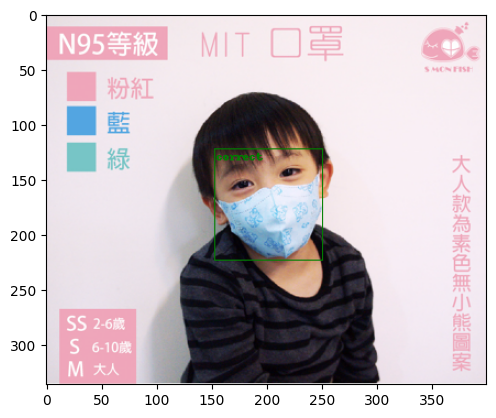

In [ ]:
lbl2name = ['shifted', 'correct', 'wrong']

def plot(image, target):
  colors = ['yellow', 'green', 'red']
  image = (image * 255.).type(torch.uint8)
  image = draw_bounding_boxes(
      image,
      target['boxes'],
      [lbl2name[x] for x in target['labels'].tolist()],
      [colors[x] for x in target['labels'].tolist()]
  )
  plt.imshow(image.permute(1, 2, 0))
  plt.show()

image, target = dataset[np.random.choice(len(dataset))]
plot(image, target)

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [.8, .2])

def collate_fn(batch):
  return tuple(zip(*batch))

train_loader = DataLoader(
    train_set,
    batch_size=4,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_set,
    batch_size=4,
    shuffle=False,
    pin_memory=True,
    num_workers=8,
    collate_fn=collate_fn
)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 10
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-3, momentum=.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
from IPython.display import clear_output

class Averager:
  def __init__(self):
    self.val = .0
    self.count = 0

  def value(self):
    if self.count == 0: return 0
    return self.val / self.count

  def send(self, val):
    self.val += val
    self.count += 1

  def reset(self):
    self.val = .0
    self.count = 0

def plot_loss(train_losses, val_losses):
  clear_output()
  plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', c='red')
  plt.plot(range(1, len(val_losses) + 1), val_losses, label='validation', c='blue')
  plt.legend()
  plt.show()

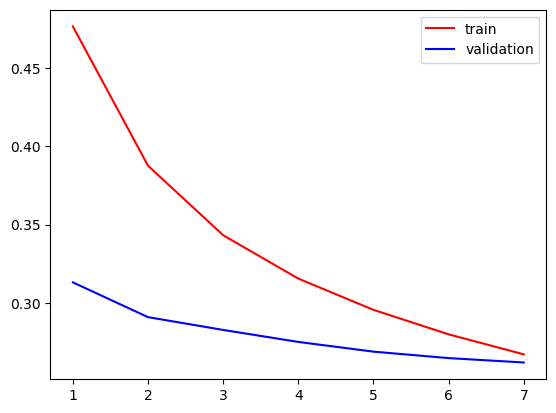

In [ ]:
loss_hist = Averager()
val_loss_hist = Averager()
losses = []
val_losses = []
model = model.to(device)
model.train()
for epoch in range(num_epochs):
  for images, targets in tqdm(train_loader, desc=f'Train: {epoch + 1}/{num_epochs}'):
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
    loss_dict = model(images, targets)
    loss = sum(loss_ for loss_ in loss_dict.values())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_hist.send(loss.item())

  losses.append(loss_hist.value())
  scheduler.step()
  with torch.no_grad():
    for images, targets in tqdm(test_loader, desc=f'Test: {epoch + 1}/{num_epochs}'):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        loss_dict = model(images, targets)
        loss = sum(loss_ for loss_ in loss_dict.values())
        val_loss_hist.send(loss.item())

  val_losses.append(val_loss_hist.value())
  plot_loss(losses, val_losses)


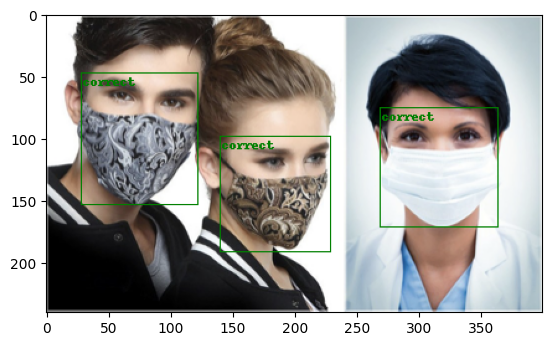

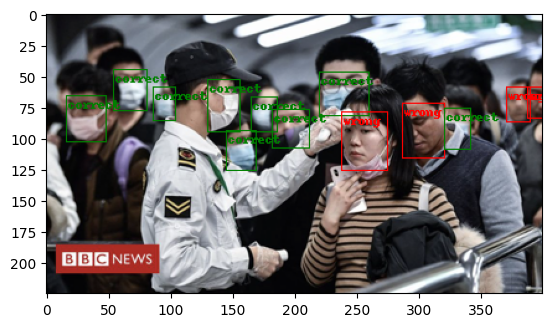

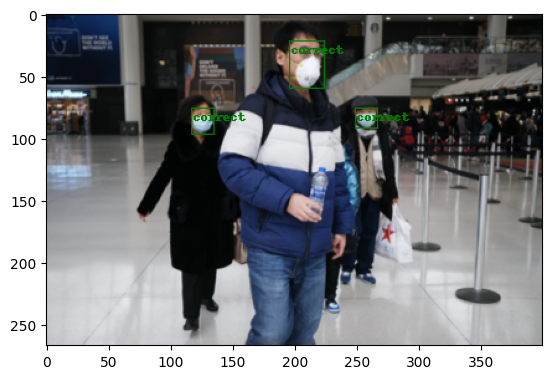

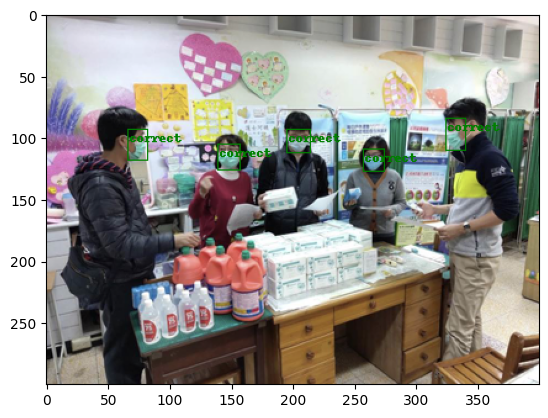

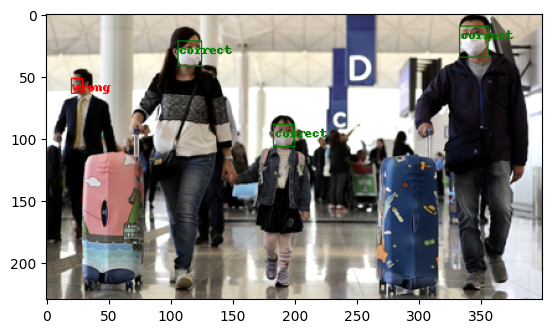

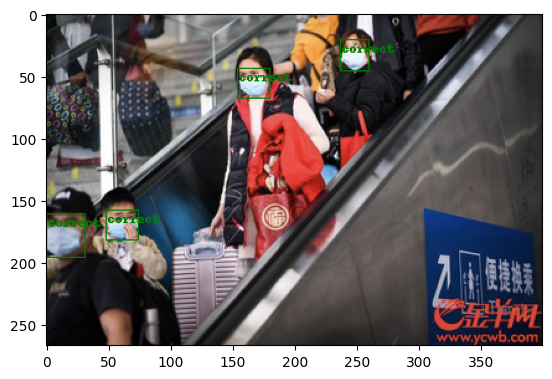

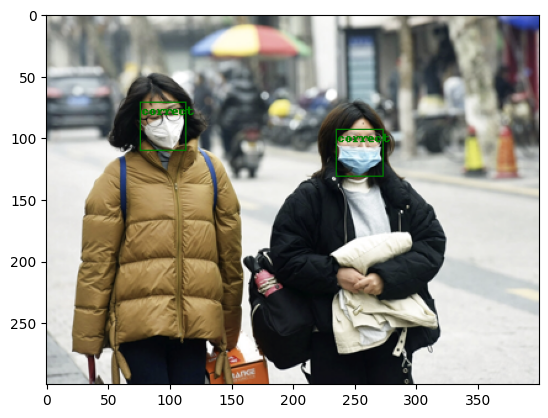

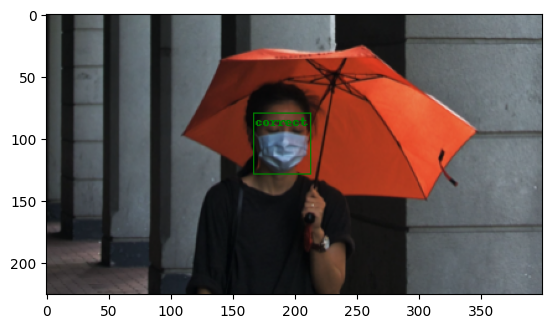

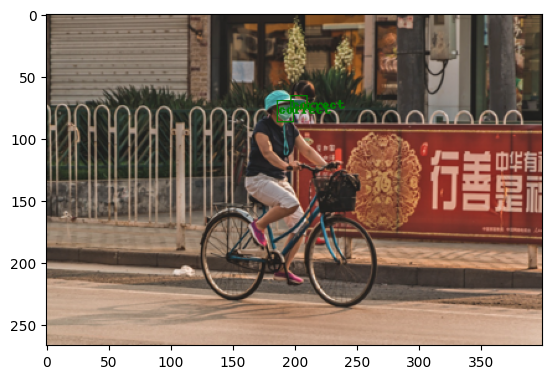

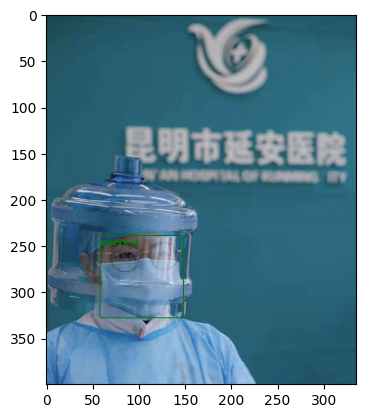

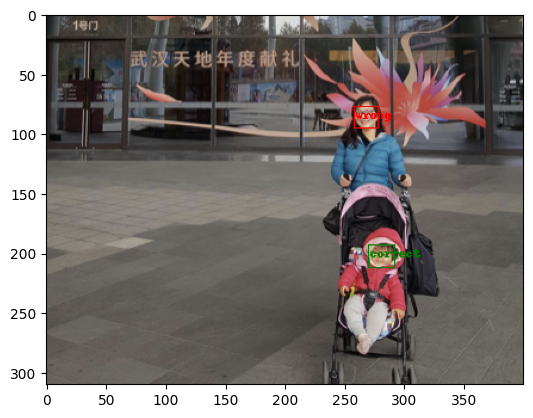

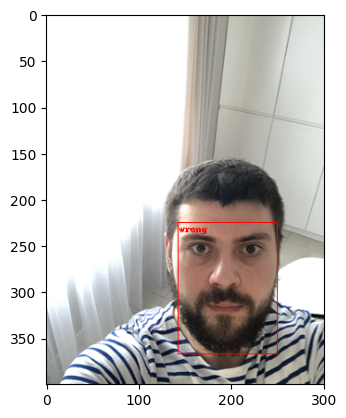

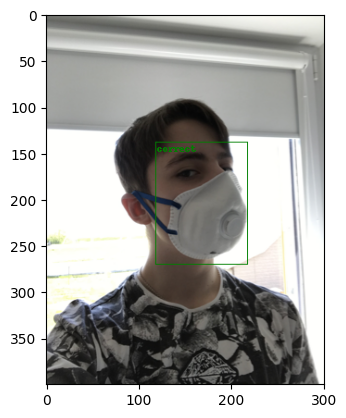

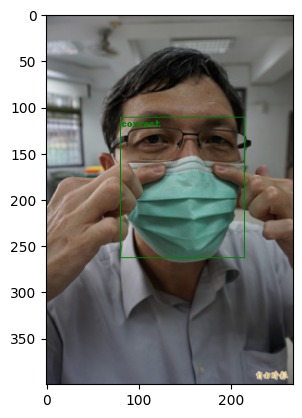

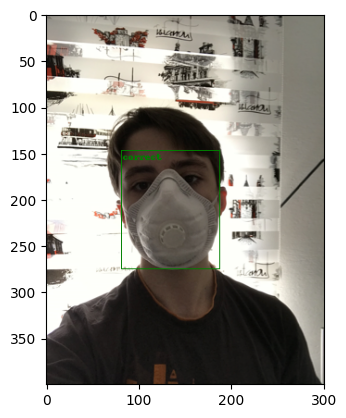

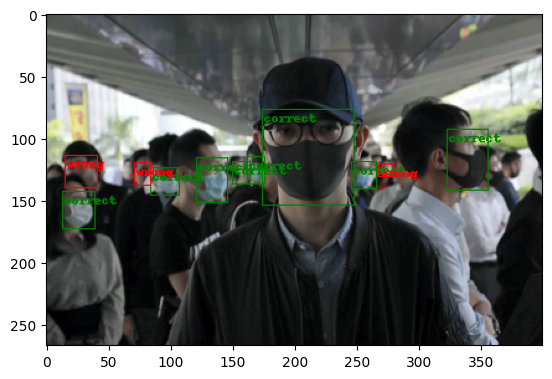

In [ ]:
@torch.no_grad()
def show(count=2, threshold=.7):
  model.eval()
  iter_ = iter(test_loader)
  for _ in range(count):
    images, _ = next(iter_)
    images = [image.to(device) for image in images]
    predictions = model(images)
    for image, target in zip(images, predictions):
      mask = target['scores'] > threshold
      boxes = target['boxes'][mask]
      labels = target['labels'][mask]
      target = {'boxes': boxes, 'labels': labels}
      if len(boxes) == 0: continue
      plot(image, target)

show(count=4, threshold=.7)

In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
  torch.cuda.empty_cache()
